In [29]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import seaborn as sns
import time
from numpy.random import seed
seed(1)

tf.keras.utils.set_random_seed(1)


def plotCorrelationGraph(modelDataList, x="nodes_in_layers", y="accuracy"):
    x_arr = []
    y_arr = []
    for modelData in modelDataList:
        x_arr.append(modelData[x])
        y_arr.append(modelData[y])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.plot(x_arr, y_arr)
    plt.show()

def cleanPredictions(predictions):
    _predictions = []
    for p in predictions:
        _predictions.append(np.argmax(p))
    return _predictions

def meassureAccuracy(predictions, y_test):
    test = predictions == y_test
    count = np.count_nonzero(test)
    accuracy = count/len(y_test)
    return accuracy

def printChosenParams(modelData, accuracy=True, weight_constraint=True, loss=True, use_cnn=True, nodes_in_layers=True, epochs=True, drop=True, add_dense_layer=True, time=True):
    string = ""
    if accuracy:
        string+="acc: {}, ".format('{0:.3f}'.format(modelData['accuracy']))
    if loss:
        string+="loss: {}, ".format('{0:.3f}'.format(modelData['loss']))
    if time:
        string+="time: {}, ".format('{0:.2f}'.format(modelData['elapsed_time']))
    if nodes_in_layers:
        string+="npl: {}, ".format(modelData['nodes_in_layers'])
    if epochs:
        string+="epochs: {}, ".format(modelData['epochs'])
    if drop:
        string+="drop: {}, ".format(modelData['drop'])
    if add_dense_layer:
        string+="extra_layers: {}, ".format(modelData['add_dense_layer'])
    if weight_constraint:
        string+="weight_constraint: {}, ".format(modelData['weight_constraint'])
    if use_cnn:
        cnn = ""
        if modelData['use_cnn']==1:
            cnn="yes"
        else:
            cnn="no"
        string+="convolutional layer: {}, ".format(cnn)
    
    print(string)


def onlyShowErrors(_cm):
    cm = _cm
    for i in range(0,10):
        cm[i][i]=0
    return cm


def mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, param_object_list):
    tested_models = []
    counter = 1
    for params in param_object_list:
        print("{}/{} {} started..".format(counter, len(param_object_list), params))
        weight=0
        if len(params)==6:
            weight=params[5]
        
        modelData = trainAndEvaluateModel(
            x_train, y_train, x_test, y_test,
            use_cnn=params[0].astype(int),
            nodes_in_layers=params[1].astype(int),
            epochs=params[2].astype(int),
            drop=params[3],
            add_dense_layer=params[4],
            weight_constraint=weight
        )
        tested_models.append(modelData)
        print("Done.Drop: {}, Acc: {}, time: {} ".format(modelData['drop'], '{0:.3f}'.format(modelData['accuracy']), modelData['elapsed_time']))
        counter+=1
        
    sortedList = sorted(tested_models, key=lambda d: d['accuracy'], reverse=True)
    return sortedList


def trainAndEvaluateModel(x_train, y_train, x_val, y_val, use_cnn=0,
                          nodes_in_layers=32,
                          epochs=10,
                          drop=0,
                          add_dense_layer=0,
                          weight_constraint=0):
    model = tf.keras.models.Sequential()
    if use_cnn==1:
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                                         input_shape=(28, 28, 1)))
        #model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.Dropout(drop, seed=3))
        model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    else:
        model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
        model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu,))
        model.add(tf.keras.layers.Dropout(drop, seed=1))
    if weight_constraint!=0:
            model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu,
                                    kernel_constraint= tf.keras.constraints.max_norm(weight_constraint)))
    else:
            model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu))
    if add_dense_layer==1:
        model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(drop, seed=2))
    model.add(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    end = time.time()
    elapsed_time = end - start

    loss, accuracy = model.evaluate(x_val, y_val)
    
    returnValue = {}
    returnValue['description'] = "accuracy: {}, nodes_in_layers: {}, epochs: {}, drop: {}, time:{}, extra_layers: {},  use_cnn: {} ".format('{0:.3f}'.format(accuracy), nodes_in_layers, epochs, drop, '{0:.2f}'.format(elapsed_time), add_dense_layer, use_cnn)
    returnValue['elapsed_time'] = elapsed_time
    returnValue['accuracy'] = accuracy
    returnValue['loss'] = loss
    returnValue['drop'] = drop
    returnValue['use_cnn'] = use_cnn
    returnValue['epochs'] = epochs
    returnValue['add_dense_layer'] = add_dense_layer
    returnValue['nodes_in_layers'] = nodes_in_layers
    returnValue['weight_constraint'] = weight_constraint
    returnValue['predictions'] = cleanPredictions(model.predict(x_val))
    return returnValue



In [14]:
####################################################
## Load dataset and split into train-validate-test##
####################################################
mnist = tf.keras.datasets.mnist
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data() #This dataset is not randomized
x_train_val = tf.keras.utils.normalize(x_train_val, axis=1)
x_train = x_train_val[:48000]
x_val = x_train_val[48000:]
y_train = y_train_val[:48000]
y_val = y_train_val[48000:]

x_test = tf.keras.utils.normalize(x_test, axis=1)

print("Done loading dataset")

Done loading dataset


In [19]:
tf.keras.utils.set_random_seed(1)
seed(1)

###################################
## This block is testing neurons ##
###################################
#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
npltest_epochs = 4
parameters_to_test = np.array([[0, 8, npltest_epochs, 0, 0],
                               [0, 16, npltest_epochs, 0, 0],
                               [0, 32, npltest_epochs, 0, 0],
                               [0, 64, npltest_epochs, 0, 0],
                               [0, 128, npltest_epochs, 0, 0],
                               [0, 200, npltest_epochs, 0, 0],
                               [0, 250, npltest_epochs, 0, 0],
                               [0, 300, npltest_epochs, 0, 0],
                               [0, 350, npltest_epochs, 0, 0],
                               [0, 400, npltest_epochs, 0, 0],
                              ])
#Testing the significance of the number of neurons
tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_val, y_val, parameters_to_test)

1/10 [0 8 4 0 0] started..
Epoch 1/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.8716 - accuracy: 0.7247
Epoch 2/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4443 - accuracy: 0.8658
Epoch 3/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3845 - accuracy: 0.8831
Epoch 4/4
375/375 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.900, time: 8.508822441101074 
2/10 [ 0 16  4  0  0] started..
Epoch 1/4
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5422 - accuracy: 0.8472
Epoch 2/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2807 - accuracy: 0.9182
Epoch 3/4
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2410 - accuracy: 0.9293
Epoch 4/4
375/375 [==============================] - 0s 920us/step
Done.Drop: 0, Acc: 0.942, time: 8.971956491470337 
3/10 [ 0 32  4  0  0] started..
Epoch 1/4
1500/1500 [==============================] - 3s 1ms/step - 

acc: 0.975, loss: 0.093, npl: 400, extra_layers: 0, 
acc: 0.974, loss: 0.088, npl: 300, extra_layers: 0, 
acc: 0.973, loss: 0.091, npl: 200, extra_layers: 0, 
acc: 0.973, loss: 0.094, npl: 250, extra_layers: 0, 
acc: 0.971, loss: 0.095, npl: 128, extra_layers: 0, 
acc: 0.971, loss: 0.098, npl: 350, extra_layers: 0, 
acc: 0.964, loss: 0.115, npl: 64, extra_layers: 0, 
acc: 0.952, loss: 0.156, npl: 32, extra_layers: 0, 
acc: 0.942, loss: 0.208, npl: 16, extra_layers: 0, 
acc: 0.900, loss: 0.332, npl: 8, extra_layers: 0, 


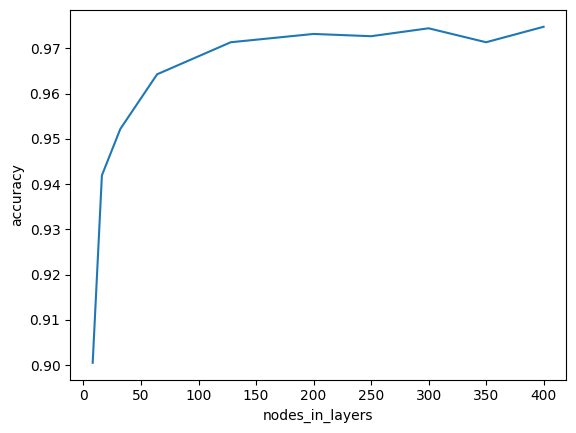

In [20]:
#Printing models from best to worst
for modelData in tested_models:
    printChosenParams(modelData, use_cnn=False, epochs=False, drop=False, time=False, weight_constraint=False)

#Plotting result
sortedList = sorted(tested_models, key=lambda d: d['nodes_in_layers'], reverse=False)
plotCorrelationGraph(sortedList, x="nodes_in_layers", y="accuracy")


In [25]:

###################################
## This block is testing dropout ##
###################################
nodes=128
epochs=5

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
drop_parameters_to_test = np.array([[0, nodes, epochs, 0, 0],
                               [0, nodes, epochs, 0.1, 0],
                               [0, nodes, epochs, 0.2, 0],
                               [0, nodes, epochs, 0.25, 0],
                               [0, nodes, epochs, 0.3, 0],
                              ])

drop_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_val, y_val, drop_parameters_to_test)


1/5 [  0. 128.   5.   0.   0.] started..
Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2924 - accuracy: 0.9143
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1170 - accuracy: 0.9644
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0784 - accuracy: 0.9753
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0572 - accuracy: 0.9811
Epoch 5/5
375/375 [==============================] - 1s 2ms/step
Done.Drop: 0.0, Acc: 0.967, time: 19.78926134109497 
2/5 [0.00e+00 1.28e+02 5.00e+00 1.00e-01 0.00e+00] started..
Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3268 - accuracy: 0.9036
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1414 - accuracy: 0.9575
Epoch 3/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1017 - accuracy: 0.9677
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss

acc: 0.973, loss: 0.093, npl: 128, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.973, loss: 0.094, npl: 128, drop: 0.25, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.973, loss: 0.095, npl: 128, drop: 0.1, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.970, loss: 0.098, npl: 128, drop: 0.3, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.967, loss: 0.107, npl: 128, drop: 0.0, extra_layers: 0.0, weight_constraint: 0, 


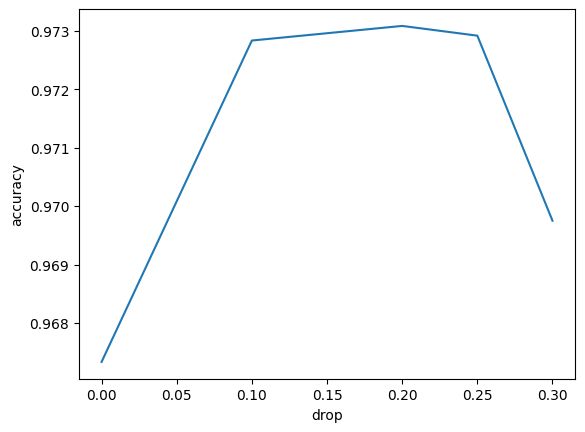

In [26]:

#Printing models from best performance to worst
for modelData in drop_tested_models:
    printChosenParams(modelData, use_cnn=False, epochs=False, time=False)

sortedList = sorted(drop_tested_models, key=lambda d: d['drop'], reverse=False)
plotCorrelationGraph(sortedList, x="drop", y="accuracy")


In [27]:
###################################
## This block is testing epochs ##
###################################
nodes=128
drop=0.2

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
epoch_parameters_to_test = np.array([[0, nodes, 1, drop, 0],
                               [0, nodes, 3, drop, 0],
                               [0, nodes, 5, drop, 0],
                               [0, nodes, 10, drop, 0],
                              ])
#Testing the significance of the number of neurons and if an extra layer adds to the accuracy
epoch_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_val, y_val, epoch_parameters_to_test)


1/4 [  0.  128.    1.    0.2   0. ] started..
375/375 [==============================] - 1s 2ms/step
Done.Drop: 0.2, Acc: 0.951, time: 3.5977396965026855 
2/4 [  0.  128.    3.    0.2   0. ] started..
Epoch 1/3
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3584 - accuracy: 0.8931
Epoch 2/3
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1690 - accuracy: 0.9495
Epoch 3/3
375/375 [==============================] - 0s 1ms/step
Done.Drop: 0.2, Acc: 0.968, time: 9.53624415397644 
3/4 [  0.  128.    5.    0.2   0. ] started..
Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3580 - accuracy: 0.8923
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1658 - accuracy: 0.9501
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1233 - accuracy: 0.9619
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1025 - accuracy: 0.9678
Epoch 5/5
375/375 [===========

acc: 0.976, loss: 0.098, time: 29.03, npl: 128, epochs: 10, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.973, loss: 0.095, time: 14.19, npl: 128, epochs: 5, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.968, loss: 0.108, time: 9.54, npl: 128, epochs: 3, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, 
acc: 0.951, loss: 0.169, time: 3.60, npl: 128, epochs: 1, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, 


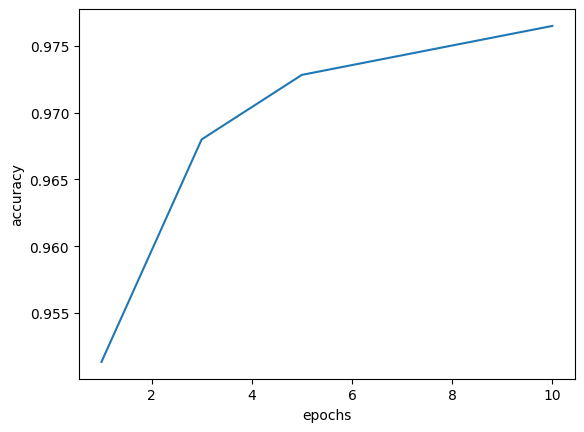

In [28]:

#Printing models from best to worst
for modelData in epoch_tested_models:
    printChosenParams(modelData, use_cnn=False,)

sortedList = sorted(epoch_tested_models, key=lambda d: d['epochs'], reverse=False)
plotCorrelationGraph(sortedList, x="epochs", y="accuracy")

In [30]:
################################################################
## This block compares dense and convolutional layer##
################################################################
nodes=128
drop=0.2
epochs=5

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
cnn_parameters_to_test = np.array([[1, nodes, epochs, drop, 1],
                               [0, nodes, epochs, drop, 0]])

cnn_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_val, y_val, cnn_parameters_to_test)




1/2 [  1.  128.    5.    0.2   1. ] started..
Epoch 1/5
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2176 - accuracy: 0.9333
Epoch 2/5
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0724 - accuracy: 0.9783
Epoch 3/5
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0455 - accuracy: 0.9855
Epoch 4/5
1500/1500 [==============================] - 40s 26ms/step - loss: 0.0315 - accuracy: 0.9900
Epoch 5/5
375/375 [==============================] - 2s 6ms/step
Done.Drop: 0.2, Acc: 0.979, time: 197.14238834381104 
2/2 [  0.  128.    5.    0.2   0. ] started..
Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3589 - accuracy: 0.8923
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1639 - accuracy: 0.9507
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1241 - accuracy: 0.9617
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss:

In [31]:
#Printing models from best to worst
for modelData in cnn_tested_models:
    printChosenParams(modelData, epochs=False)

acc: 0.979, loss: 0.079, time: 197.14, npl: 128, drop: 0.2, extra_layers: 1.0, weight_constraint: 0, convolutional layer: yes, 
acc: 0.969, loss: 0.099, time: 15.12, npl: 128, drop: 0.2, extra_layers: 0.0, weight_constraint: 0, convolutional layer: no, 


0.058848362416028976 0.9851666688919067
375/375 [==============================] - 4s 11ms/step


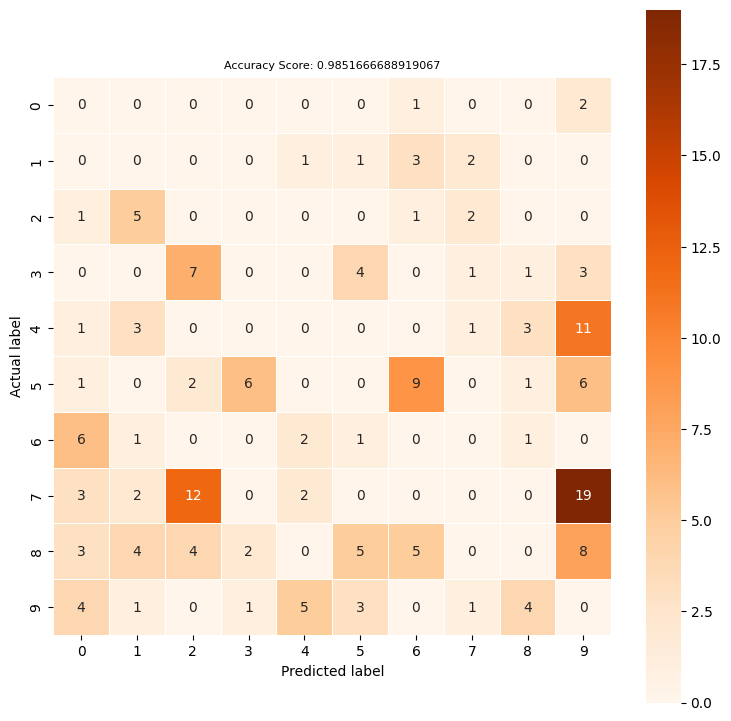

In [35]:
#################################################
## Printing confusionmodel for that model #######
#################################################
print(loss, accuracy)
predictions = cleanPredictions(model.predict(x_val))
cm = metrics.confusion_matrix(y_val, predictions)
error_cm = onlyShowErrors(cm)

plt.figure(figsize=(9,9))
sns.heatmap(error_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 8);


In [43]:
###############################################
## Testing adding another maxpooling layer##
###############################################

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(28, 28, 1)
                                )
         )
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dropout(0.2, seed=4))
model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=6)
loss, accuracy = model.evaluate(x_val, y_val)


Epoch 1/6
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1904 - accuracy: 0.9416
Epoch 2/6
1500/1500 [==============================] - 22s 14ms/step - loss: 0.0633 - accuracy: 0.9805
Epoch 3/6
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0450 - accuracy: 0.9855
Epoch 4/6
1500/1500 [==============================] - 22s 14ms/step - loss: 0.0331 - accuracy: 0.9894
Epoch 5/6
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0267 - accuracy: 0.9912
Epoch 6/6
375/375 [==============================] - 2s 5ms/step - loss: 0.0342 - accuracy: 0.9908


0.03424607962369919 0.9908333420753479
375/375 [==============================] - 2s 5ms/step


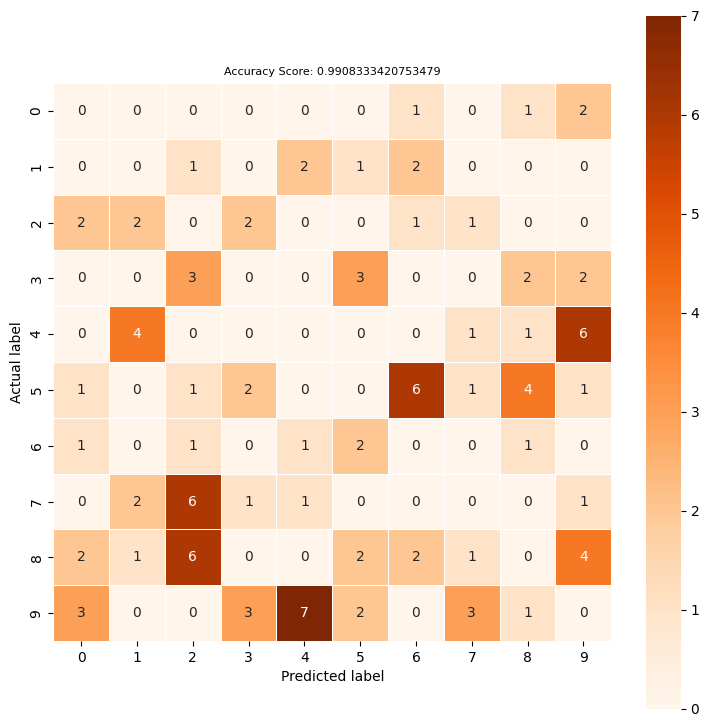

In [44]:
##############################################################
## Printing confusionmatrix for the model with pooling #######
##############################################################
print(loss, accuracy)
predictions = cleanPredictions(model.predict(x_val))
cm = metrics.confusion_matrix(y_val, predictions)
error_cm = onlyShowErrors(cm)

plt.figure(figsize=(9,9))
sns.heatmap(error_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 8);


In [117]:
################################################################
## Finally training using the discovered "best" values        ##
################################################################
nodes=250
drop=0.3
epochs=50

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
c_parameters_to_test = np.array([[1, nodes, epochs, drop, 1]])

c_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, c_parameters_to_test)

1/1 started..
Epoch 1/50
1875/1875 [==============================] - 156s 83ms/step - loss: 0.1387 - accuracy: 0.9571
Epoch 2/50
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0456 - accuracy: 0.9862
Epoch 3/50
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0307 - accuracy: 0.9902
Epoch 4/50
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0215 - accuracy: 0.9936
Epoch 5/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0175 - accuracy: 0.9947
Epoch 6/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0113 - accuracy: 0.9962
Epoch 7/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0114 - accuracy: 0.9970
Epoch 8/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0102 - accuracy: 0.9970
Epoch 9/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0105 - accuracy: 0.9972
Epoch 10/50
1875/1875 [==================

In [118]:

printChosenParams(c_tested_models[0], epochs=False)

acc: 0.985, loss: 0.335, time: 29169.26, npl: 250, drop: 0.3, extra_layers: 1.0, convolutional layer: yes, 


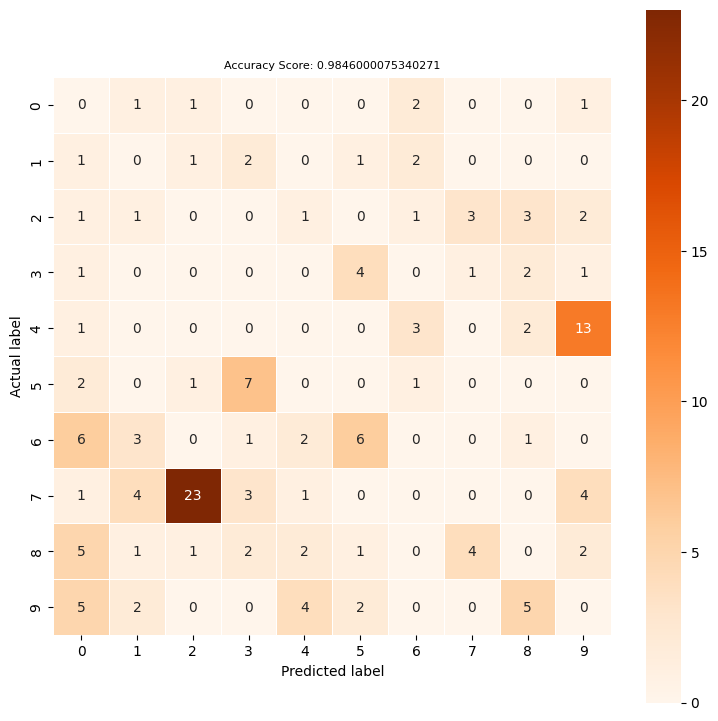

In [119]:
_modelData = c_tested_models[0]

predictions = _modelData['predictions']
cm = metrics.confusion_matrix(y_test, predictions)
error_cm = onlyShowErrors(cm)

plt.figure(figsize=(9,9))
sns.heatmap(error_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(_modelData['accuracy'])
plt.title(all_sample_title, size = 8);

In [142]:
###################################
## This block is testing neurons ##
###################################
#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1, weight_constraint]
weighttest_epochs = 6
weight_parameters_to_test = np.array([
                               [0, 128, weighttest_epochs, 0.3, 0, 2],
                               [0, 128, weighttest_epochs, 0.3, 0, 4],
                               [0, 128, weighttest_epochs, 0.3, 0, 6],
                               [0, 128, weighttest_epochs, 0.3, 0, 8],
                               [0, 128, weighttest_epochs, 0.3, 0, 10],
                               [0, 128, weighttest_epochs, 0.3, 0, 12],
                               [0, 128, weighttest_epochs, 0.3, 0, 14],
                               [1, 128, weighttest_epochs, 0.3, 1, 2],
                               [1, 128, weighttest_epochs, 0.3, 1, 4],
                               [1, 128, weighttest_epochs, 0.3, 1, 6],
                               [1, 128, weighttest_epochs, 0.3, 1, 8],
                               [1, 128, weighttest_epochs, 0.3, 1, 10],
                               [1, 128, weighttest_epochs, 0.3, 1, 12],
                               [1, 128, weighttest_epochs, 0.3, 1, 14],
                              ])
#Testing the significance of weight constraints
weight_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, weight_parameters_to_test)

#Printing models from best to worst
for modelData in weight_tested_models:
    printChosenParams(modelData, epochs=False, drop=False, time=False)

1/14 [  0.  128.    6.    0.3   0.    2. ] started..
Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3738 - accuracy: 0.8883
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1834 - accuracy: 0.9451
Epoch 3/6
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1422 - accuracy: 0.9566
Epoch 4/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1206 - accuracy: 0.9633
Epoch 5/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1078 - accuracy: 0.9667
Epoch 6/6
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0.3, Acc: 0.973, time: 45.714627504348755 
2/14 [  0.  128.    6.    0.3   0.    4. ] started..
Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3754 - accuracy: 0.8874
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1834 - accuracy: 0.9440
Epoch 3/6
1875/1875 [==============================] - 8s 4ms/step -

14
[14.0, 12.0, 10.0, 8.0, 6.0, 4.0, 2.0]
[14.0, 12.0, 10.0, 8.0, 6.0, 4.0, 2.0]


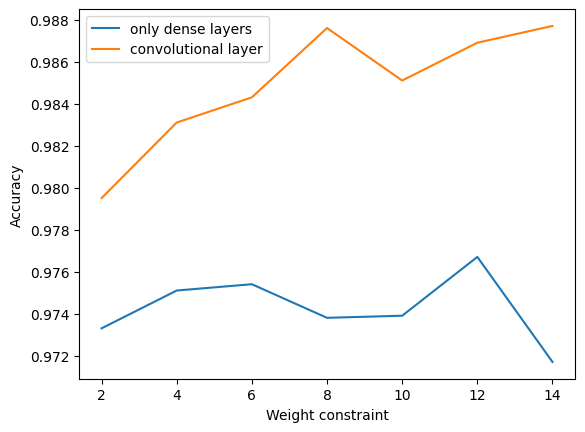

In [145]:
    x_arr = []
    y_arr = []
    x_arr_cnn = []
    y_arr_cnn = []
    sorted_cnn_List = sorted(weight_tested_models[:7], key=lambda d: d['weight_constraint'], reverse=True)
    sorted_dense_List = sorted(weight_tested_models[7:], key=lambda d: d['weight_constraint'], reverse=True)
    
    
    for modelData in sorted_cnn_List:
        x_arr_cnn.append(modelData['weight_constraint'])
        y_arr_cnn.append(modelData['accuracy'])
    for modelData in sorted_dense_List:
        x_arr.append(modelData['weight_constraint'])
        y_arr.append(modelData['accuracy'])                      
    
    print(len(weight_tested_models))
    print(x_arr)
    print(x_arr_cnn)
    
    
    plt.ylabel("Accuracy")
    plt.xlabel("Weight constraint")
    plt.plot(x_arr, y_arr, label="only dense layers")
    plt.plot(x_arr_cnn, y_arr_cnn, label="convolutional layer")
    plt.legend()
    plt.show()

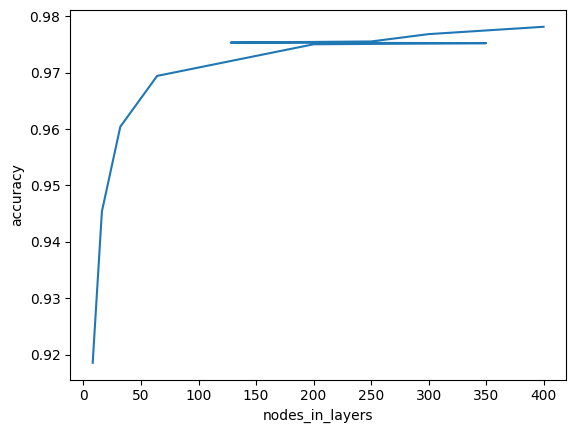

In [102]:
plotCorrelationGraph(tested_models)